# Preparation to work with Google Colab

In [2]:
#Mount google drive as your hardisk
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PROJECT_PATH = '/content/drive/My Drive/Springboard/Take_home_assignment_1/ultimate_challenge/'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import pickle
import json
import urllib.request

# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account inJanuary 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­ term rider retention (again, a few sentences will suffice).
Data description

- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY MM DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

### Analysis for question 1

In [0]:
# load the login data
FILE = 'ultimate_data_challenge.json'
with open(PROJECT_PATH +  FILE) as json_file:
    data_challenge = json.load(json_file)
    json_file.close()

In [0]:
challenge_df = pd.DataFrame(data_challenge)

In [7]:
challenge_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [0]:
assert len(data_challenge) == challenge_df.shape[0]

In [0]:
assert len(data_challenge[0]) == challenge_df.shape[1]

In [10]:
challenge_df.shape

(50000, 12)

In [11]:
challenge_df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


In [12]:
challenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [13]:
challenge_df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [14]:
challenge_df.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct'],
      dtype='object')

In [15]:
selected_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
                     'last_trip_date',  'signup_date', 'surge_pct',
                    'trips_in_first_30_days',  'weekday_pct']
for c in selected_columns:
  print('Column: {}, Min: {}, Max: {}'.format(c, challenge_df[c].min(), challenge_df[c].max()))

Column: avg_dist, Min: 0.0, Max: 160.96
Column: avg_rating_by_driver, Min: 1.0, Max: 5.0
Column: avg_rating_of_driver, Min: 1.0, Max: 5.0
Column: avg_surge, Min: 1.0, Max: 8.0
Column: last_trip_date, Min: 2014-01-01, Max: 2014-07-01
Column: signup_date, Min: 2014-01-01, Max: 2014-01-31
Column: surge_pct, Min: 0.0, Max: 100.0
Column: trips_in_first_30_days, Min: 0, Max: 125
Column: weekday_pct, Min: 0.0, Max: 100.0


In [0]:
# create column retained, if  last_trip_date occurred in the preceding 30 days
# considering that the last trip happened on 2014-07-01,
# retained customers are  the ones who last trip happened from 2014-06-01
challenge_df['retained'] = False
challenge_df.loc[challenge_df['last_trip_date'] >= '2014-06-01' ,'retained'] = True

In [17]:
# 
num_retained  =  challenge_df.retained.sum()
total = len(challenge_df)
print('Number of retained customers: {}, {:.2f}%'.format(num_retained, num_retained/total*100))

Number of retained customers: 18804, 37.61%


In [0]:
import seaborn as sns

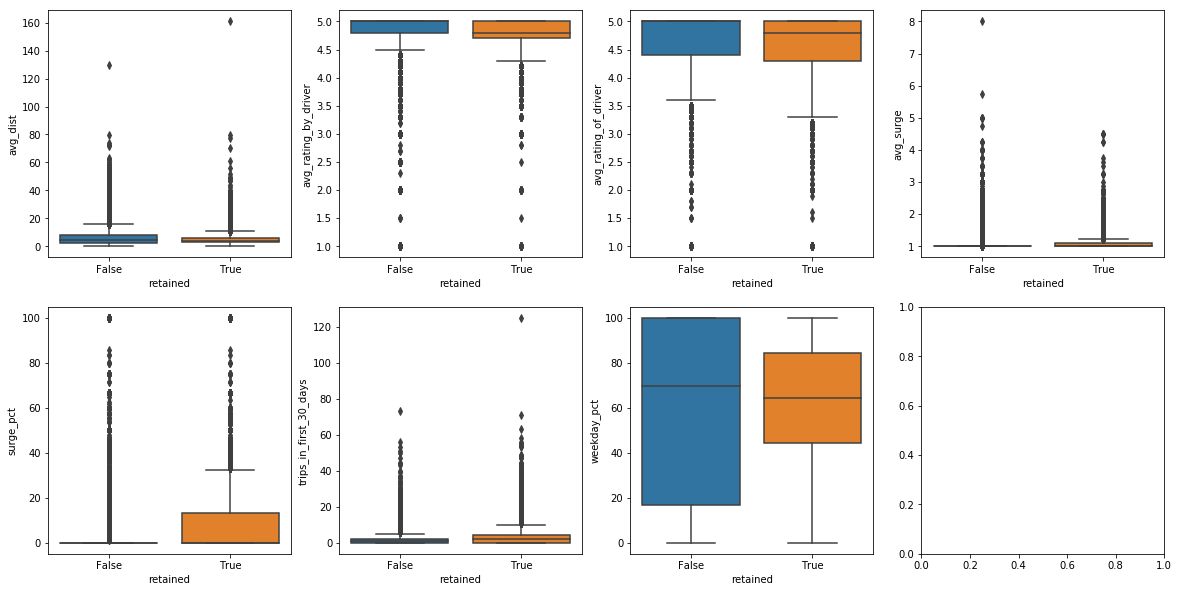

In [19]:
selected_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
                    'surge_pct', 'trips_in_first_30_days',  'weekday_pct']
f, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
for i, c in zip(axes.flatten(), selected_columns):
  sns.boxplot(x = 'retained', y= c, data = challenge_df, ax=i)

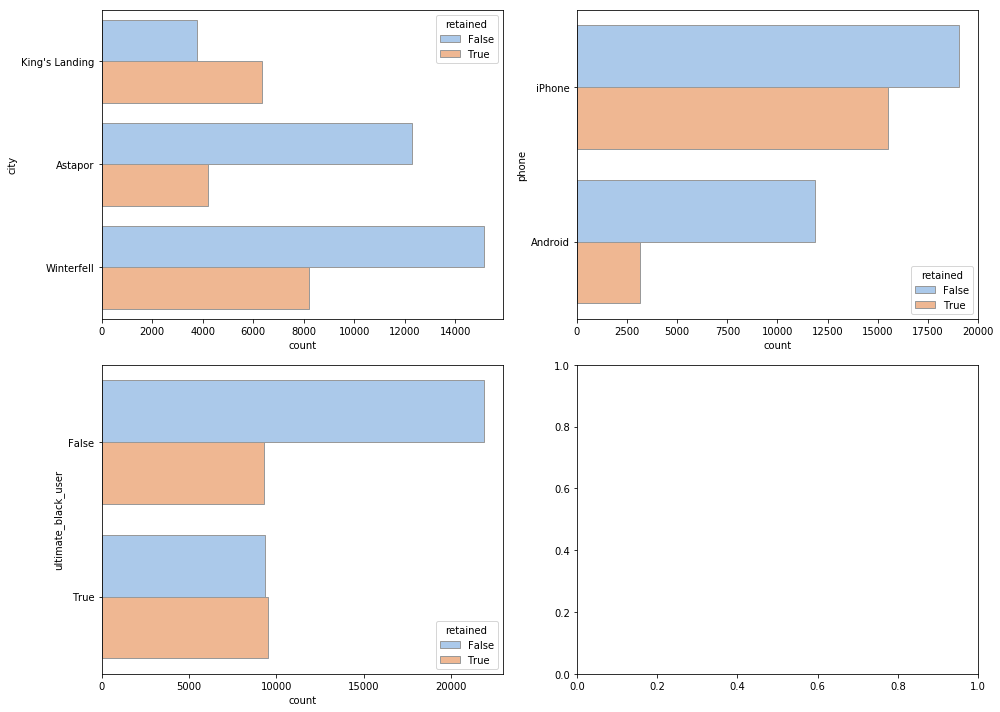

In [20]:
selected_columns = ['city',  'phone',  'ultimate_black_user']
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

for i, c in zip(axes.flatten(), selected_columns):
  sns.catplot(y=c, hue='retained', kind='count',
            palette='pastel', edgecolor='.6',
            data=challenge_df, ax=i)
plt.close(2)
plt.close(3)
plt.close(4)
f.tight_layout()

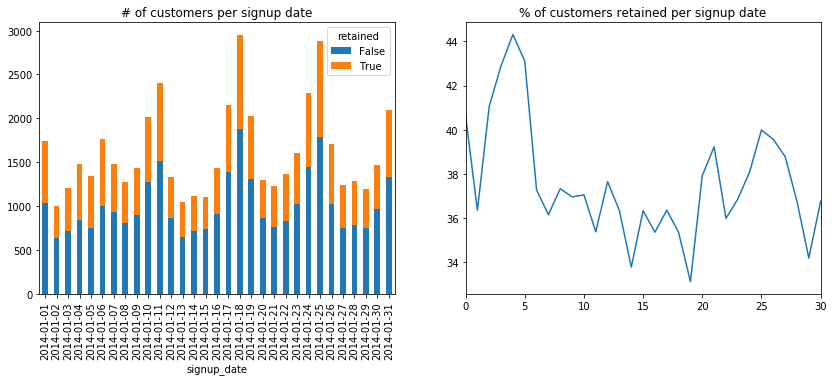

In [21]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
group_signup = challenge_df.groupby(['signup_date','retained']).size().reset_index().pivot(
    columns='retained', index='signup_date', values=0)
group_signup.plot(kind='bar', stacked=True, ax = axes[0])
group_signup.reset_index(inplace=True)
group_signup['Perc_True']=group_signup[True]/(group_signup[True]+group_signup[False])*100
group_signup['Perc_True'].plot(kind='line', ax = axes[1])
axes[0].set_title('# of customers per signup date')
axes[1].set_title('% of customers retained per signup date')
plt.show()

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

A.: **37.61%** of customers were retained.
We also found from the exploratory analysis thathave missing values for:
- avg_rating_by_driver
- avg_rating_of_driver
- phone

Some variables present outliers, in the form of extremely high values:
- avg_dist, Max: 160.96
- trips_in_first_30_days, Max: 125
- avg_surge, Max: 8

Also the distributions depicted on box plot charts and count charts, indicate that we might expect that some variables might be good predictors of retention. They are:
- surge_pct
- weekend_pct
- city
- phone
- ultimate_black_user


### Modelling for question 2

In [22]:
challenge_df.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct',
       'retained'],
      dtype='object')

In [0]:
# Create labels
y = challenge_df.retained*1

In [0]:
# Create features
selected_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
                    'city', 'phone', 'signup_date', 'surge_pct',
                    'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct'] 
#last trip data is exclude because it would leak the target label
X = challenge_df[selected_features].copy()

In [25]:
X.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,Android,2014-01-27,11.8,14,False,82.4


In [0]:
# treatment of categorical features: city, phone and ultimate_black_user
# treat missing values for phone including label 'unknown'
X.phone.fillna('unknown', inplace = True)
# convert 'ultimate_black_user' to binary
X['ultimate_black_user'] *=1
# convert 'city' and 'phone' to one-hot encoding
X = pd.get_dummies(X, columns=['city', 'phone'])

In [27]:
X.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unknown
0,3.67,5.0,4.7,1.10,2014-01-25,15.4,4,1,46.2,0,1,0,0,1,0
1,8.26,5.0,5.0,1.00,2014-01-29,0.0,0,0,50.0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,2014-01-06,0.0,3,0,100.0,1,0,0,0,1,0
3,2.36,4.9,4.6,1.14,2014-01-10,20.0,9,1,80.0,0,1,0,0,1,0
4,3.13,4.9,4.4,1.19,2014-01-27,11.8,14,0,82.4,0,0,1,1,0,0


In [0]:
# Extracting the day from 'signup_date'
X['signup_day'] = X['signup_date'].str[-2:].astype(int)
X.drop('signup_date', axis =1, inplace = True)

In [0]:
# treatment of missing values for numeric values
selected_columns = ['avg_rating_by_driver', 'avg_rating_of_driver']
for c in selected_columns:
  X[c].fillna(-1, inplace = True)

In [0]:
# separate train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.2, random_state=101)

In [0]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [32]:
# First attemp with a logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
 
Cs = [0.001, 0.1, 1, 10, 100]
parameters = { 'C' : Cs}
metric = 'accuracy'
lr = LogisticRegression(solver='lbfgs')
clf = GridSearchCV(lr, parameters, scoring = metric, cv=5)
clf.fit(X_train_scaled, y_train)
clf_best = clf.best_estimator_ 
score = accuracy_score(clf_best.predict(X_test_scaled), y_test)
score_train = accuracy_score(clf_best.predict(X_train_scaled), y_train)
best_C_grid = clf.best_params_['C']
print('Best C: {}, resulted score: {} for the held-out test data and {} for the train set'.format(best_C_grid, score, score_train))
y_pred = clf_best.predict(X_test_scaled)
print('Accuracy: {:.3f}%'.format(score*100.0))
print('F1 Score: {:.3f}%'.format(f1_score(y_test, y_pred)*100))
print('Precision Score: {:.3f}%'.format(precision_score(y_test, y_pred)*100))
print('Recall Score: {:.3f}%'.format(recall_score(y_test, y_pred)*100))

Best C: 1, resulted score: 0.7225 for the held-out test data and 0.7228 for the train set
Accuracy: 72.250%
F1 Score: 57.679%
Precision Score: 67.319%
Recall Score: 50.454%


In [33]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 101)
# Train the model on training data
parameters = { 'max_depth' : [3, 5, 8, 10]}
clf = GridSearchCV(rf, parameters, scoring = metric, cv=5)
clf.fit(X_train_scaled, y_train)
clf_best = clf.best_estimator_ 
score = accuracy_score(clf_best.predict(X_test_scaled), y_test)
score_train = accuracy_score(clf_best.predict(X_train_scaled), y_train)
best_max_depth_grid = clf.best_params_['max_depth']
print('Best max_depth: {}, resulted score: {} for the held-out test data and {} for the train set'.format(best_max_depth_grid, score, score_train))

Best max_depth: 10, resulted score: 0.7792 for the held-out test data and 0.810425 for the train set


Accuracy: 77.920%
F1 Score: 68.520%
Precision Score: 73.576%
Recall Score: 64.114%


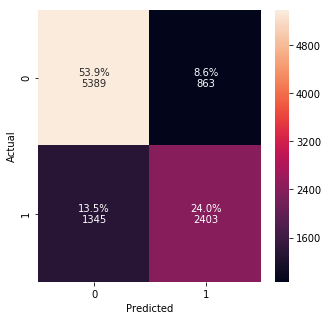

In [34]:
print('Accuracy: {:.3f}%'.format(score*100.0))
y_pred = clf_best.predict(X_test_scaled)
print('F1 Score: {:.3f}%'.format(f1_score(y_test, y_pred)*100))
print('Precision Score: {:.3f}%'.format(precision_score(y_test, y_pred)*100))
print('Recall Score: {:.3f}%'.format(recall_score(y_test, y_pred)*100)) 


def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = cm.sum()
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                
                annot[i, j] = '%.1f%%\n%d' % (p, c)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred, clf_best.classes_, ymap=None, figsize=(5,5))

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

A.: We created a classifier to determine if the customer would be active in the 6th month.  The approach we used:

- we used all categorical features, and coded them with one-hot-encoding
- For missing values in phone, we include the tag "unknown" and for avg_rating_of_driver and avg_rating_by_driver, we included a magic number -1
- We applied standard scaling for the dataset
- We firstly attempted a logist regression model, trying several different parameters C, getting an accuracy of 72.3%
- We also tried a random forest classifier, with different max_depth parameters, which performed better with a 77.9% accuracy 

So we decided, to use the random forest model which had the following main scores:
- Accuracy: 77.920%
- F1 Score: 68.520%
- Precision Score: 73.576%
- Recall Score: 64.114% 

### Question 3 insights from the model

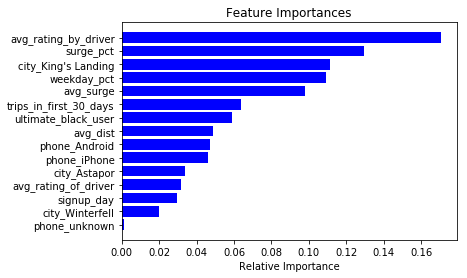

In [36]:
features=X.columns
importances = clf_best.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [68]:
!pip install shap

     |████████████████████████████████| 245kB 4.8MB/s 
  Created wheel for shap: filename=shap-0.30.0-cp36-cp36m-linux_x86_64.whl size=356758 sha256=31a8dec070ba4867f9387e2da70e1f11246d4e949ee73259435bed6754f0d80b
  Stored in directory: /root/.cache/pip/wheels/67/7a/5b/34feab81170fb8bf642a7536b5127e54e00bce373564435808
Successfully built shap


In [0]:
import shap

In [0]:
explainerRF = shap.TreeExplainer(clf_best)
shap_values_RF_test = explainerRF.shap_values(X_test)

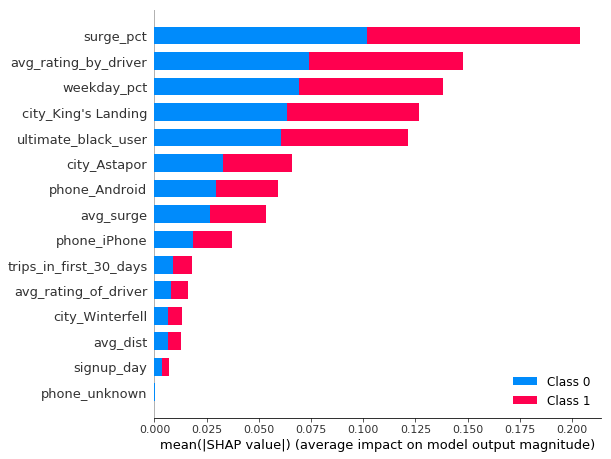

In [45]:
 shap.summary_plot(shap_values_RF_test, X_test)

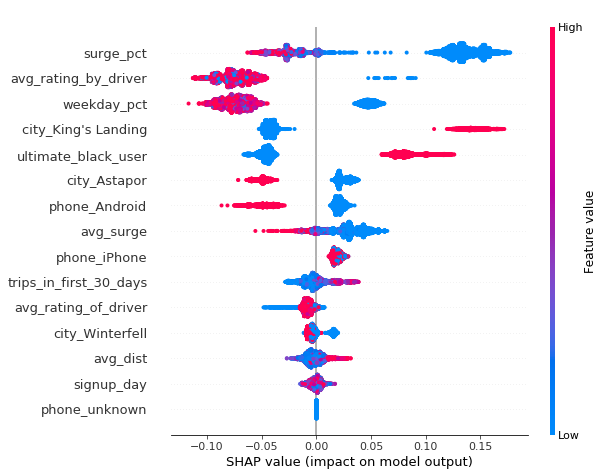

In [53]:
shap.summary_plot(shap_values_RF_test[1], X_test)

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­ term rider retention (again, a few sentences will suffice). 

A.: This model shows that some factor influence the probability of a customer to be retained:
- If a customer experienced surge tarifs frequently, he/she is less likely to be retained
- Customers not rated or low rated by drivers tend to be retained
- Customers that used the service predominantely during the weekdays tend to not be retained
- King's Landing and ultimate_black_users tend to be retained
- i-phone users tend to be retained

The results indicates that price sensitiveness might be influencing the retention: customers that paid more in surge tend to not stay. Customer that are less price sensitive, who use the black service or are i-phone users (reputably an expensive produc) tend to be loyal.
We also see more retention among the customers that make a casual usage of the services during the weekend. Customers that make frequent, and likely professional, usage during weekdays tend not to be retained.